# Welcome!

This ipython notebook implements three simple Neural Nets that try to classify the MNIST dataset:
* (Vanilla_NN): Vanilla Neural Network
* (BN_Drop_NN): Slightly fancier Neural Network with Dropout and Batch Normalization
* (Conv_NN): Simple Convolutional Neural Network

This code is aimed for those who understand the basics of Neural Networks, and want to see an actual practical implementation.

As such, this code doesn't use any higher level libraries such as Tensorflow. It only makes extensive use of Numpy.

Hopefully this will give you an easy to follow code and a good overview of what happens inside the Neural Nets step by step.


Files description:

* Data_MNIST:		folder that should contain all the data, please download these yourself 
* Models.py:             script that contains athe three networks as python classes
* NN_utils.py:           script that contains all library of main neural network functions
* NeuralNets.ipynb       (this file) ipython notebook that instantiates the network classes from Models.py, and trains them etc. More description inside.

Lacking:

* Actually, the three models are not that different. It would be nice to merge them, with API that lets you toggle on/off BN and dropout and conv
* Now each net is its own class, would be easier to create new nets if they were all just daughters of a parent general net class
* ReLU layer, other activation functions
* Visualize different nets training characteristics next to each other
* max Pool or other pooling function would be nice addition
* variable stride and padding for conv nets
* ...


## Import Libraries

In [2]:
from matplotlib import pyplot as plt
import struct
import numpy as np
from Models   import *
from nn_utils import *

# ipython magic reloading
%load_ext autoreload
%autoreload 2

# Import data
## MAKE SURE YOU DOWNLOAD THE MNIST DATASET YOURSELF, and put the files in the correct folder.
## They are NOT automatically included in this repository.
## You can easily download them from: http://yann.lecun.com/exdb/mnist/

In [3]:
# this loading code is based on Akesling's GitHub, who in turn bases his code on
# http://abel.ee.ucla.edu/cvxopt/_downloads/mnist.py

# paths to the data files. Again, make sure you put these there yourself!
tr_img_path = 'Data_MNIST/train-images.idx3-ubyte'  # data file for training images
tr_lbl_path = 'Data_MNIST/train-labels.idx1-ubyte'  # data file for training labels
te_img_path = 'Data_MNIST/t10k-images.idx3-ubyte'   # data file for testing images
te_lbl_path = 'Data_MNIST/t10k-labels.idx1-ubyte'   # data file for testing labels

# import trinaing images (tr_img):
# N_Tr is number of training samples, H is sample height (28) and W is sample width (28)
with open(tr_img_path, 'rb') as tr_full_img_file:
    magic, N_tr_full, H, W  = struct.unpack('>IIII', tr_full_img_file.read(16))
    tr_full_img             = np.fromfile(tr_full_img_file, dtype=np.uint8).reshape(N_tr_full, H, W)

# import training labels (tr_lbl):
with open(tr_lbl_path, 'rb') as tr_full_lbl_file:
    magic, _                = struct.unpack('>II', tr_full_lbl_file.read(8))
    tr_full_lbl_1D          = np.fromfile(tr_full_lbl_file, dtype=np.uint8)

# import trinaing images (tr_img):
# N_Te is number of testing samples,
with open(te_img_path, 'rb') as te_img_file:
    magic, N_te, _, _       = struct.unpack('>IIII', te_img_file.read(16))
    te_img                  = np.fromfile(te_img_file, dtype=np.uint8).reshape(N_te, H, W)

# import training labels (tr_lbl):
with open(te_lbl_path, 'rb') as te_lbl_file:
    magic, _                = struct.unpack('>II', te_lbl_file.read(8))
    te_lbl_1D               = np.fromfile(te_lbl_file, dtype=np.uint8)

# the MNIST data set doesnt contain any validation set, so lets subsample one randomly from the training set:
N_va   = N_te                       # decide validation set size, now taken similar to the test set size
N_tr   = N_tr_full - N_va           # new training set size
idx    = np.arange(N_tr+N_va)       # create N indices of the size of the old size training set
np.random.shuffle(idx)              # random shuffle the indices
idx_tr = idx[:N_tr ]                # get random indices for training samples
idx_va = idx[ N_tr:]                # get rest of the random indices for validation samples

tr_img = tr_full_img[idx_tr]
va_img = tr_full_img[idx_va]
tr_lbl_1D = tr_full_lbl_1D[idx_tr]
va_lbl_1D = tr_full_lbl_1D[idx_va]

print('Training images have shape: ',tr_img.shape, 'training labels have shape: ',tr_lbl_1D.shape)
print('Validation images have shape: ',va_img.shape, 'validation labels have shape: ',va_lbl_1D.shape)
print('Testing images have shape: ',te_img.shape, 'testing labels have shape: ',te_lbl_1D.shape)

Training images have shape:  (50000, 28, 28) training labels have shape:  (50000,)
Validation images have shape:  (10000, 28, 28) validation labels have shape:  (10000,)
Testing images have shape:  (10000, 28, 28) testing labels have shape:  (10000,)


## Currently, the labels are 1D numpy arrays with entries in [0-9]. To classify the images with a Neural Network, it is easier to make the labels one-hot encoded 2D numpy arrays:

In [4]:
# one hot encode the training labels
C      = np.max(tr_lbl_1D) + 1                      # number of classes (+1 cause 0 is also a class)
tr_lbl = np.zeros((N_tr, C))                        # initialise empty an empty array for the one hot encoded training labels
tr_lbl[np.arange(N_tr), tr_lbl_1D.astype(int)] = 1  # one hot encode the training labels

# same, for the validation labels
va_lbl = np.zeros((N_va, C))
va_lbl[np.arange(N_va), va_lbl_1D.astype(int)] = 1

# and the same for the testing labels
te_lbl = np.zeros((N_te, C))
te_lbl[np.arange(N_te), te_lbl_1D.astype(int)] = 1

print('old training labels have shape: ',tr_lbl_1D.shape, 'new training labels have shape: ', tr_lbl.shape)
print('old validation labels have shape: ',va_lbl_1D.shape,  'new validation labels have shape: ',  va_lbl.shape)
print('old testing labels have shape: ',te_lbl_1D.shape,  'new testing labels have shape: ',  te_lbl.shape)

old training labels have shape:  (50000,) new training labels have shape:  (50000, 10)
old validation labels have shape:  (10000,) new validation labels have shape:  (10000, 10)
old testing labels have shape:  (10000,) new testing labels have shape:  (10000, 10)


# Show data
### Alway good to know the data we're working with


H & W of the images: 28 ,  28
# of classes: 10
random example:
image class/label one hot: [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.] , or non one hot: 2


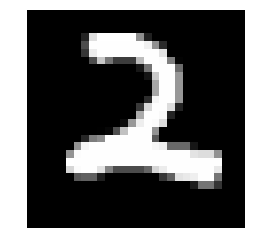

In [5]:
# get random sample index, rerun this cell for different samples
sample_id = np.random.randint(tr_img.shape[0])

print('H & W of the images:', H, ', ', W)
print('# of classes:', C)
print('random example:')
print('image class/label one hot:', tr_lbl[sample_id], ', or non one hot:', np.argmax(tr_lbl[sample_id]))

plt.imshow(tr_img[sample_id], cmap=plt.gray())
plt.axis('off')
plt.show()

In [7]:
# If you want to debug, or just check inside the code, it might we worth it to take a smaller dataset for speed up

tr_img = tr_img[:1000]
tr_lbl = tr_lbl[:1000]
va_img = va_img[:1000]
va_lbl = va_lbl[:1000]
te_img = te_img[:1000]
te_lbl = te_lbl[:1000]
N_tr, N_va, N_te = 1000, 1000, 1000

# Time for the fun stuff! First the Vanilla_NN network!

In [71]:
# Hyperparameters, you should play around with these!:

layer_sizes = [100, 50, 25]  # size per hidden layer

num_epoch   = 100            # total number of epochs for training
batch_size  = 100            # batch size of training samples per forward and backward pass
lrn_rate    = 7e-3           # learning rate for stochastic gradient descent
reg_str     = 0              # regularization strenght (L2 implemented)
print_every = 2             # during training, print current performance every this amount of iterations

# a Vanilla net takes a flat feature array as input instead of a 2D image, so change the shape of the images:
tr_img_flat = tr_img.reshape(N_tr, -1)
va_img_flat = va_img.reshape(N_va, -1)
te_img_flat = te_img.reshape(N_te, -1)

# initialise a Vanilla network class, please look in the Models.py file for its API and workings
VanNet = Vanilla_NN(input_size       = (H*W),
                    layer_sizes      = layer_sizes,
                    output_size      = C)
# train
tr_loss_hist, va_loss_hist, tr_acc_hist, va_acc_hist = VanNet.train(tr_img_flat, tr_lbl, va_img_flat, va_lbl,
                                                                    number_epochs = num_epoch,
                                                                    batch_size    = batch_size,
                                                                    learning_rate = lrn_rate,
                                                                    reg_strength  = reg_str,
                                                                    print_every   = print_every,
                                                                    verbose       = True)

print('\nfinal training loss: %.4f' % (tr_loss_hist[-1]))
print('final training accuracy: %.2f, best validation accuracy: %.2f' % (tr_acc_hist[-1], np.max(va_acc_hist)))

# test
loss, pred, final_test_accuracy = VanNet.test(te_img_flat, te_lbl)
print('\nfinal test accuracy: %.2f' % final_test_accuracy)

C:\Users\Anner\Documents\Werk\LeapMind\nn_utils.py:179: RuntimeWarning: overflow encountered in exp
  out   = 1 / (1 + np.exp(-un_act))


iteration    0/1000, training accuracy: 0.06, training loss: 2.3568
iteration    2/1000, training accuracy: 0.16, training loss: 2.2040
iteration    4/1000, training accuracy: 0.16, training loss: 2.1947


iteration    6/1000, training accuracy: 0.16, training loss: 2.1918
iteration    8/1000, training accuracy: 0.16, training loss: 2.1900


iteration   10/1000, training accuracy: 0.16, training loss: 2.1891
iteration   12/1000, training accuracy: 0.16, training loss: 2.1892
iteration   14/1000, training accuracy: 0.16, training loss: 2.1884


iteration   16/1000, training accuracy: 0.16, training loss: 2.1876
iteration   18/1000, training accuracy: 0.16, training loss: 2.1871
iteration   20/1000, training accuracy: 0.16, training loss: 2.1860


iteration   22/1000, training accuracy: 0.16, training loss: 2.1844
iteration   24/1000, training accuracy: 0.16, training loss: 2.1836
iteration   26/1000, training accuracy: 0.16, training loss: 2.1821


iteration   28/1000, training accuracy: 0.16, training loss: 2.1818
iteration   30/1000, training accuracy: 0.16, training loss: 2.1807


iteration   32/1000, training accuracy: 0.17, training loss: 2.1796
iteration   34/1000, training accuracy: 0.19, training loss: 2.1789
iteration   36/1000, training accuracy: 0.19, training loss: 2.1770


iteration   38/1000, training accuracy: 0.20, training loss: 2.1758
iteration   40/1000, training accuracy: 0.20, training loss: 2.1746
iteration   42/1000, training accuracy: 0.20, training loss: 2.1713


iteration   44/1000, training accuracy: 0.21, training loss: 2.1689
iteration   46/1000, training accuracy: 0.21, training loss: 2.1674
iteration   48/1000, training accuracy: 0.21, training loss: 2.1651


iteration   50/1000, training accuracy: 0.20, training loss: 2.1650
iteration   52/1000, training accuracy: 0.20, training loss: 2.1618
iteration   54/1000, training accuracy: 0.19, training loss: 2.1588


iteration   56/1000, training accuracy: 0.18, training loss: 2.1539
iteration   58/1000, training accuracy: 0.16, training loss: 2.1487
iteration   60/1000, training accuracy: 0.16, training loss: 2.1626


iteration   62/1000, training accuracy: 0.16, training loss: 2.1841
iteration   64/1000, training accuracy: 0.22, training loss: 2.0779
iteration   66/1000, training accuracy: 0.16, training loss: 2.1801


iteration   68/1000, training accuracy: 0.20, training loss: 2.1739
iteration   70/1000, training accuracy: 0.31, training loss: 1.9944
iteration   72/1000, training accuracy: 0.28, training loss: 2.0440


iteration   74/1000, training accuracy: 0.16, training loss: 2.1819
iteration   76/1000, training accuracy: 0.16, training loss: 2.4002


iteration   78/1000, training accuracy: 0.32, training loss: 1.9212
iteration   80/1000, training accuracy: 0.34, training loss: 1.8714


iteration   82/1000, training accuracy: 0.33, training loss: 1.8688
iteration   84/1000, training accuracy: 0.33, training loss: 1.8987
iteration   86/1000, training accuracy: 0.32, training loss: 1.9703


iteration   88/1000, training accuracy: 0.11, training loss: 2.2730
iteration   90/1000, training accuracy: 0.21, training loss: 2.1851
iteration   92/1000, training accuracy: 0.26, training loss: 1.9594


iteration   94/1000, training accuracy: 0.26, training loss: 1.9257
iteration   96/1000, training accuracy: 0.26, training loss: 1.9170
iteration   98/1000, training accuracy: 0.26, training loss: 1.9110


iteration  100/1000, training accuracy: 0.28, training loss: 1.9045
iteration  102/1000, training accuracy: 0.29, training loss: 1.8978
iteration  104/1000, training accuracy: 0.29, training loss: 1.8930


iteration  106/1000, training accuracy: 0.29, training loss: 1.8809
iteration  108/1000, training accuracy: 0.31, training loss: 1.8647
iteration  110/1000, training accuracy: 0.32, training loss: 1.8365


iteration  112/1000, training accuracy: 0.32, training loss: 1.8260
iteration  114/1000, training accuracy: 0.35, training loss: 1.7992
iteration  116/1000, training accuracy: 0.37, training loss: 1.7973


iteration  118/1000, training accuracy: 0.34, training loss: 1.8216
iteration  120/1000, training accuracy: 0.34, training loss: 1.8413
iteration  122/1000, training accuracy: 0.31, training loss: 1.8456


iteration  124/1000, training accuracy: 0.31, training loss: 1.8518
iteration  126/1000, training accuracy: 0.30, training loss: 1.8871
iteration  128/1000, training accuracy: 0.11, training loss: 2.4807


iteration  130/1000, training accuracy: 0.15, training loss: 2.3987
iteration  132/1000, training accuracy: 0.24, training loss: 2.0151


iteration  134/1000, training accuracy: 0.24, training loss: 1.9509
iteration  136/1000, training accuracy: 0.24, training loss: 1.9345


iteration  138/1000, training accuracy: 0.26, training loss: 1.9233
iteration  140/1000, training accuracy: 0.26, training loss: 1.9208
iteration  142/1000, training accuracy: 0.26, training loss: 1.9021


iteration  144/1000, training accuracy: 0.26, training loss: 1.8976
iteration  146/1000, training accuracy: 0.26, training loss: 1.8943
iteration  148/1000, training accuracy: 0.27, training loss: 1.8957


iteration  150/1000, training accuracy: 0.27, training loss: 1.8973
iteration  152/1000, training accuracy: 0.26, training loss: 1.8998
iteration  154/1000, training accuracy: 0.26, training loss: 1.8973


iteration  156/1000, training accuracy: 0.26, training loss: 1.8842
iteration  158/1000, training accuracy: 0.26, training loss: 1.8786
iteration  160/1000, training accuracy: 0.26, training loss: 1.8848


iteration  162/1000, training accuracy: 0.26, training loss: 1.8725
iteration  164/1000, training accuracy: 0.26, training loss: 1.8844
iteration  166/1000, training accuracy: 0.26, training loss: 1.8913


iteration  168/1000, training accuracy: 0.26, training loss: 1.8698
iteration  170/1000, training accuracy: 0.26, training loss: 1.8887
iteration  172/1000, training accuracy: 0.26, training loss: 1.8780


iteration  174/1000, training accuracy: 0.26, training loss: 1.8866
iteration  176/1000, training accuracy: 0.26, training loss: 1.8645
iteration  178/1000, training accuracy: 0.27, training loss: 1.8585


iteration  180/1000, training accuracy: 0.30, training loss: 1.8395
iteration  182/1000, training accuracy: 0.30, training loss: 1.8499


iteration  184/1000, training accuracy: 0.35, training loss: 1.8437
iteration  186/1000, training accuracy: 0.37, training loss: 1.8735
iteration  188/1000, training accuracy: 0.28, training loss: 1.9033


iteration  190/1000, training accuracy: 0.27, training loss: 1.8933
iteration  192/1000, training accuracy: 0.28, training loss: 1.8828
iteration  194/1000, training accuracy: 0.28, training loss: 1.8686


iteration  196/1000, training accuracy: 0.28, training loss: 1.8552
iteration  198/1000, training accuracy: 0.28, training loss: 1.8446
iteration  200/1000, training accuracy: 0.27, training loss: 1.8565


iteration  202/1000, training accuracy: 0.26, training loss: 1.9049
iteration  204/1000, training accuracy: 0.27, training loss: 1.8861
iteration  206/1000, training accuracy: 0.26, training loss: 1.8849


iteration  208/1000, training accuracy: 0.26, training loss: 1.8860
iteration  210/1000, training accuracy: 0.27, training loss: 1.8883
iteration  212/1000, training accuracy: 0.27, training loss: 1.8812


iteration  214/1000, training accuracy: 0.26, training loss: 1.9050
iteration  216/1000, training accuracy: 0.23, training loss: 1.8760
iteration  218/1000, training accuracy: 0.24, training loss: 1.8742


iteration  220/1000, training accuracy: 0.24, training loss: 1.8601
iteration  222/1000, training accuracy: 0.26, training loss: 1.8442
iteration  224/1000, training accuracy: 0.29, training loss: 1.7758


iteration  226/1000, training accuracy: 0.30, training loss: 1.8274
iteration  228/1000, training accuracy: 0.25, training loss: 1.9110
iteration  230/1000, training accuracy: 0.32, training loss: 1.8126


iteration  232/1000, training accuracy: 0.29, training loss: 1.8903
iteration  234/1000, training accuracy: 0.29, training loss: 1.8624


iteration  236/1000, training accuracy: 0.29, training loss: 1.8632
iteration  238/1000, training accuracy: 0.31, training loss: 1.8165


iteration  240/1000, training accuracy: 0.30, training loss: 1.8887
iteration  242/1000, training accuracy: 0.29, training loss: 1.8887
iteration  244/1000, training accuracy: 0.31, training loss: 1.8529


iteration  246/1000, training accuracy: 0.33, training loss: 1.8059
iteration  248/1000, training accuracy: 0.28, training loss: 1.9254
iteration  250/1000, training accuracy: 0.27, training loss: 1.9014


iteration  252/1000, training accuracy: 0.30, training loss: 1.6842
iteration  254/1000, training accuracy: 0.28, training loss: 1.9093
iteration  256/1000, training accuracy: 0.27, training loss: 1.8572


iteration  258/1000, training accuracy: 0.29, training loss: 1.6923
iteration  260/1000, training accuracy: 0.27, training loss: 1.9150
iteration  262/1000, training accuracy: 0.32, training loss: 1.6475


iteration  264/1000, training accuracy: 0.35, training loss: 1.6364
iteration  266/1000, training accuracy: 0.30, training loss: 1.8341


iteration  268/1000, training accuracy: 0.25, training loss: 1.9897
iteration  270/1000, training accuracy: 0.33, training loss: 1.6631


iteration  272/1000, training accuracy: 0.32, training loss: 1.7937
iteration  274/1000, training accuracy: 0.33, training loss: 1.7386
iteration  276/1000, training accuracy: 0.31, training loss: 1.8288


iteration  278/1000, training accuracy: 0.33, training loss: 1.7278
iteration  280/1000, training accuracy: 0.35, training loss: 1.6931
iteration  282/1000, training accuracy: 0.35, training loss: 1.7146


iteration  284/1000, training accuracy: 0.32, training loss: 1.8460
iteration  286/1000, training accuracy: 0.26, training loss: 1.9399
iteration  288/1000, training accuracy: 0.35, training loss: 1.5926


iteration  290/1000, training accuracy: 0.35, training loss: 1.6983
iteration  292/1000, training accuracy: 0.35, training loss: 1.7151
iteration  294/1000, training accuracy: 0.38, training loss: 1.4788


iteration  296/1000, training accuracy: 0.35, training loss: 1.6418
iteration  298/1000, training accuracy: 0.34, training loss: 1.8047
iteration  300/1000, training accuracy: 0.33, training loss: 1.7961


iteration  302/1000, training accuracy: 0.35, training loss: 1.6921
iteration  304/1000, training accuracy: 0.32, training loss: 1.7725
iteration  306/1000, training accuracy: 0.33, training loss: 1.7699


iteration  308/1000, training accuracy: 0.32, training loss: 1.7470
iteration  310/1000, training accuracy: 0.32, training loss: 1.8759
iteration  312/1000, training accuracy: 0.31, training loss: 1.8345


iteration  314/1000, training accuracy: 0.36, training loss: 1.5919
iteration  316/1000, training accuracy: 0.33, training loss: 1.6913
iteration  318/1000, training accuracy: 0.34, training loss: 1.7879


iteration  320/1000, training accuracy: 0.36, training loss: 1.6440
iteration  322/1000, training accuracy: 0.41, training loss: 1.5992
iteration  324/1000, training accuracy: 0.32, training loss: 1.8159


iteration  326/1000, training accuracy: 0.31, training loss: 1.9593
iteration  328/1000, training accuracy: 0.39, training loss: 1.4639


iteration  330/1000, training accuracy: 0.47, training loss: 1.5682
iteration  332/1000, training accuracy: 0.36, training loss: 1.6977
iteration  334/1000, training accuracy: 0.32, training loss: 1.8561


iteration  336/1000, training accuracy: 0.28, training loss: 2.0278
iteration  338/1000, training accuracy: 0.39, training loss: 1.6872
iteration  340/1000, training accuracy: 0.31, training loss: 1.9578


iteration  342/1000, training accuracy: 0.40, training loss: 1.6350
iteration  344/1000, training accuracy: 0.38, training loss: 1.7485
iteration  346/1000, training accuracy: 0.36, training loss: 1.7594


iteration  348/1000, training accuracy: 0.38, training loss: 1.7515
iteration  350/1000, training accuracy: 0.40, training loss: 1.7592
iteration  352/1000, training accuracy: 0.43, training loss: 1.7313


iteration  354/1000, training accuracy: 0.36, training loss: 1.6675
iteration  356/1000, training accuracy: 0.36, training loss: 1.6735
iteration  358/1000, training accuracy: 0.35, training loss: 1.7343


iteration  360/1000, training accuracy: 0.26, training loss: 2.1963
iteration  362/1000, training accuracy: 0.40, training loss: 1.6862
iteration  364/1000, training accuracy: 0.38, training loss: 1.6796


iteration  366/1000, training accuracy: 0.38, training loss: 1.7106
iteration  368/1000, training accuracy: 0.38, training loss: 1.7539
iteration  370/1000, training accuracy: 0.39, training loss: 1.6706


iteration  372/1000, training accuracy: 0.41, training loss: 1.5957
iteration  374/1000, training accuracy: 0.27, training loss: 1.7371


iteration  376/1000, training accuracy: 0.43, training loss: 1.6256
iteration  378/1000, training accuracy: 0.35, training loss: 1.9074
iteration  380/1000, training accuracy: 0.30, training loss: 2.0760


iteration  382/1000, training accuracy: 0.34, training loss: 1.8107
iteration  384/1000, training accuracy: 0.43, training loss: 1.5503
iteration  386/1000, training accuracy: 0.42, training loss: 1.5981


iteration  388/1000, training accuracy: 0.33, training loss: 1.8686
iteration  390/1000, training accuracy: 0.42, training loss: 1.5803
iteration  392/1000, training accuracy: 0.36, training loss: 1.8945


iteration  394/1000, training accuracy: 0.18, training loss: 2.1051
iteration  396/1000, training accuracy: 0.46, training loss: 1.4634
iteration  398/1000, training accuracy: 0.43, training loss: 1.5372


iteration  400/1000, training accuracy: 0.32, training loss: 1.6911
iteration  402/1000, training accuracy: 0.43, training loss: 1.5597


iteration  404/1000, training accuracy: 0.42, training loss: 1.6076
iteration  406/1000, training accuracy: 0.42, training loss: 1.6605


iteration  408/1000, training accuracy: 0.37, training loss: 1.6482
iteration  410/1000, training accuracy: 0.31, training loss: 2.0156


iteration  412/1000, training accuracy: 0.41, training loss: 1.5183
iteration  414/1000, training accuracy: 0.38, training loss: 1.7113


iteration  416/1000, training accuracy: 0.28, training loss: 2.0995
iteration  418/1000, training accuracy: 0.42, training loss: 1.5379
iteration  420/1000, training accuracy: 0.41, training loss: 1.5805


iteration  422/1000, training accuracy: 0.34, training loss: 1.7658
iteration  424/1000, training accuracy: 0.33, training loss: 1.9180
iteration  426/1000, training accuracy: 0.39, training loss: 1.6347


iteration  428/1000, training accuracy: 0.42, training loss: 1.5527
iteration  430/1000, training accuracy: 0.31, training loss: 1.6907
iteration  432/1000, training accuracy: 0.37, training loss: 1.6915


iteration  434/1000, training accuracy: 0.47, training loss: 1.5324
iteration  436/1000, training accuracy: 0.22, training loss: 1.9541
iteration  438/1000, training accuracy: 0.41, training loss: 1.4696


iteration  440/1000, training accuracy: 0.39, training loss: 1.5477
iteration  442/1000, training accuracy: 0.47, training loss: 1.5604
iteration  444/1000, training accuracy: 0.47, training loss: 1.5061


iteration  446/1000, training accuracy: 0.51, training loss: 1.4479
iteration  448/1000, training accuracy: 0.32, training loss: 1.7977
iteration  450/1000, training accuracy: 0.41, training loss: 1.5111


iteration  452/1000, training accuracy: 0.43, training loss: 1.5691
iteration  454/1000, training accuracy: 0.42, training loss: 1.5889
iteration  456/1000, training accuracy: 0.41, training loss: 1.5547


iteration  458/1000, training accuracy: 0.39, training loss: 1.5759
iteration  460/1000, training accuracy: 0.37, training loss: 1.6129
iteration  462/1000, training accuracy: 0.33, training loss: 1.7778


iteration  464/1000, training accuracy: 0.39, training loss: 1.5066
iteration  466/1000, training accuracy: 0.42, training loss: 1.6106
iteration  468/1000, training accuracy: 0.32, training loss: 1.7692


iteration  470/1000, training accuracy: 0.40, training loss: 1.5181
iteration  472/1000, training accuracy: 0.45, training loss: 1.4802
iteration  474/1000, training accuracy: 0.36, training loss: 1.5134


iteration  476/1000, training accuracy: 0.43, training loss: 1.6253
iteration  478/1000, training accuracy: 0.46, training loss: 1.4710
iteration  480/1000, training accuracy: 0.42, training loss: 1.5702


iteration  482/1000, training accuracy: 0.32, training loss: 1.8767
iteration  484/1000, training accuracy: 0.40, training loss: 1.6583
iteration  486/1000, training accuracy: 0.51, training loss: 1.2988


iteration  488/1000, training accuracy: 0.46, training loss: 1.4193
iteration  490/1000, training accuracy: 0.45, training loss: 1.4921
iteration  492/1000, training accuracy: 0.39, training loss: 1.6738


iteration  494/1000, training accuracy: 0.32, training loss: 1.8548
iteration  496/1000, training accuracy: 0.50, training loss: 1.2819


iteration  498/1000, training accuracy: 0.46, training loss: 1.4044
iteration  500/1000, training accuracy: 0.33, training loss: 1.6917


iteration  502/1000, training accuracy: 0.46, training loss: 1.4717
iteration  504/1000, training accuracy: 0.42, training loss: 1.5272


iteration  506/1000, training accuracy: 0.43, training loss: 1.5397
iteration  508/1000, training accuracy: 0.46, training loss: 1.4840
iteration  510/1000, training accuracy: 0.40, training loss: 1.5213


iteration  512/1000, training accuracy: 0.40, training loss: 1.5272
iteration  514/1000, training accuracy: 0.46, training loss: 1.4947


iteration  516/1000, training accuracy: 0.35, training loss: 1.6545
iteration  518/1000, training accuracy: 0.42, training loss: 1.4944


iteration  520/1000, training accuracy: 0.40, training loss: 1.4951
iteration  522/1000, training accuracy: 0.41, training loss: 1.5828


iteration  524/1000, training accuracy: 0.36, training loss: 1.8131
iteration  526/1000, training accuracy: 0.46, training loss: 1.5219


iteration  528/1000, training accuracy: 0.40, training loss: 1.5636
iteration  530/1000, training accuracy: 0.43, training loss: 1.4586


iteration  532/1000, training accuracy: 0.51, training loss: 1.3962
iteration  534/1000, training accuracy: 0.39, training loss: 1.5726


iteration  536/1000, training accuracy: 0.32, training loss: 1.8060
iteration  538/1000, training accuracy: 0.44, training loss: 1.4496


iteration  540/1000, training accuracy: 0.50, training loss: 1.3610
iteration  542/1000, training accuracy: 0.43, training loss: 1.4654


iteration  544/1000, training accuracy: 0.46, training loss: 1.4658
iteration  546/1000, training accuracy: 0.24, training loss: 1.7952


iteration  548/1000, training accuracy: 0.36, training loss: 1.7940
iteration  550/1000, training accuracy: 0.47, training loss: 1.3637


iteration  552/1000, training accuracy: 0.48, training loss: 1.3755
iteration  554/1000, training accuracy: 0.45, training loss: 1.4203


iteration  556/1000, training accuracy: 0.45, training loss: 1.4599
iteration  558/1000, training accuracy: 0.43, training loss: 1.5773


iteration  560/1000, training accuracy: 0.36, training loss: 2.3075
iteration  562/1000, training accuracy: 0.48, training loss: 1.4391


iteration  564/1000, training accuracy: 0.39, training loss: 1.4635
iteration  566/1000, training accuracy: 0.36, training loss: 1.5076


iteration  568/1000, training accuracy: 0.40, training loss: 1.4771
iteration  570/1000, training accuracy: 0.37, training loss: 1.5418


iteration  572/1000, training accuracy: 0.47, training loss: 1.4156
iteration  574/1000, training accuracy: 0.46, training loss: 1.4064
iteration  576/1000, training accuracy: 0.43, training loss: 1.4540


iteration  578/1000, training accuracy: 0.40, training loss: 1.8580
iteration  580/1000, training accuracy: 0.41, training loss: 1.5157
iteration  582/1000, training accuracy: 0.47, training loss: 1.2950


iteration  584/1000, training accuracy: 0.45, training loss: 1.3837
iteration  586/1000, training accuracy: 0.43, training loss: 1.4398
iteration  588/1000, training accuracy: 0.38, training loss: 1.6098


iteration  590/1000, training accuracy: 0.28, training loss: 1.8270
iteration  592/1000, training accuracy: 0.43, training loss: 1.5849


iteration  594/1000, training accuracy: 0.47, training loss: 1.3839
iteration  596/1000, training accuracy: 0.49, training loss: 1.4466
iteration  598/1000, training accuracy: 0.47, training loss: 1.4574


iteration  600/1000, training accuracy: 0.45, training loss: 1.5467
iteration  602/1000, training accuracy: 0.36, training loss: 1.6689


iteration  604/1000, training accuracy: 0.46, training loss: 1.4802
iteration  606/1000, training accuracy: 0.47, training loss: 1.4006
iteration  608/1000, training accuracy: 0.46, training loss: 1.4690


iteration  610/1000, training accuracy: 0.37, training loss: 1.7718
iteration  612/1000, training accuracy: 0.46, training loss: 1.5195


iteration  614/1000, training accuracy: 0.43, training loss: 1.7837
iteration  616/1000, training accuracy: 0.43, training loss: 1.9425


iteration  618/1000, training accuracy: 0.49, training loss: 1.4957
iteration  620/1000, training accuracy: 0.47, training loss: 1.4685


iteration  622/1000, training accuracy: 0.33, training loss: 1.8309
iteration  624/1000, training accuracy: 0.44, training loss: 1.4389


iteration  626/1000, training accuracy: 0.46, training loss: 1.4378
iteration  628/1000, training accuracy: 0.34, training loss: 1.5818


iteration  630/1000, training accuracy: 0.44, training loss: 1.6434
iteration  632/1000, training accuracy: 0.45, training loss: 1.4579


iteration  634/1000, training accuracy: 0.36, training loss: 1.7802
iteration  636/1000, training accuracy: 0.42, training loss: 1.6780


iteration  638/1000, training accuracy: 0.47, training loss: 1.3758
iteration  640/1000, training accuracy: 0.47, training loss: 1.3992


iteration  642/1000, training accuracy: 0.42, training loss: 1.4389
iteration  644/1000, training accuracy: 0.39, training loss: 1.5694
iteration  646/1000, training accuracy: 0.45, training loss: 1.4546


iteration  648/1000, training accuracy: 0.43, training loss: 1.5150
iteration  650/1000, training accuracy: 0.47, training loss: 1.4374
iteration  652/1000, training accuracy: 0.44, training loss: 1.5267


iteration  654/1000, training accuracy: 0.38, training loss: 1.5761
iteration  656/1000, training accuracy: 0.41, training loss: 2.0070


iteration  658/1000, training accuracy: 0.48, training loss: 1.4924
iteration  660/1000, training accuracy: 0.46, training loss: 1.4201


iteration  662/1000, training accuracy: 0.46, training loss: 1.4401
iteration  664/1000, training accuracy: 0.51, training loss: 1.3792


iteration  666/1000, training accuracy: 0.28, training loss: 1.9024
iteration  668/1000, training accuracy: 0.32, training loss: 1.9164
iteration  670/1000, training accuracy: 0.49, training loss: 1.3719


iteration  672/1000, training accuracy: 0.48, training loss: 1.3593
iteration  674/1000, training accuracy: 0.44, training loss: 1.4319


iteration  676/1000, training accuracy: 0.45, training loss: 1.4394
iteration  678/1000, training accuracy: 0.48, training loss: 1.5795


iteration  680/1000, training accuracy: 0.46, training loss: 1.4483


iteration  682/1000, training accuracy: 0.46, training loss: 1.4020
iteration  684/1000, training accuracy: 0.39, training loss: 1.5522


iteration  686/1000, training accuracy: 0.42, training loss: 1.4792
iteration  688/1000, training accuracy: 0.46, training loss: 1.3992


iteration  690/1000, training accuracy: 0.40, training loss: 1.4703
iteration  692/1000, training accuracy: 0.38, training loss: 1.6000


iteration  694/1000, training accuracy: 0.48, training loss: 1.3520
iteration  696/1000, training accuracy: 0.45, training loss: 1.4386


iteration  698/1000, training accuracy: 0.45, training loss: 1.5047
iteration  700/1000, training accuracy: 0.42, training loss: 1.3765


iteration  702/1000, training accuracy: 0.45, training loss: 1.4576
iteration  704/1000, training accuracy: 0.41, training loss: 1.4955


iteration  706/1000, training accuracy: 0.45, training loss: 1.4590
iteration  708/1000, training accuracy: 0.50, training loss: 1.3020


iteration  710/1000, training accuracy: 0.47, training loss: 1.3746
iteration  712/1000, training accuracy: 0.38, training loss: 1.6492


iteration  714/1000, training accuracy: 0.41, training loss: 1.6477
iteration  716/1000, training accuracy: 0.53, training loss: 1.2851


iteration  718/1000, training accuracy: 0.47, training loss: 1.3442
iteration  720/1000, training accuracy: 0.45, training loss: 1.3912


iteration  722/1000, training accuracy: 0.44, training loss: 1.4510
iteration  724/1000, training accuracy: 0.24, training loss: 2.5982


iteration  726/1000, training accuracy: 0.34, training loss: 1.7719
iteration  728/1000, training accuracy: 0.48, training loss: 1.4609


iteration  730/1000, training accuracy: 0.45, training loss: 1.4251
iteration  732/1000, training accuracy: 0.44, training loss: 1.4637


iteration  734/1000, training accuracy: 0.45, training loss: 1.4904
iteration  736/1000, training accuracy: 0.40, training loss: 1.5563
iteration  738/1000, training accuracy: 0.39, training loss: 1.7237


iteration  740/1000, training accuracy: 0.45, training loss: 1.4771
iteration  742/1000, training accuracy: 0.46, training loss: 1.4804
iteration  744/1000, training accuracy: 0.44, training loss: 1.5604


iteration  746/1000, training accuracy: 0.42, training loss: 1.6546
iteration  748/1000, training accuracy: 0.40, training loss: 1.9130
iteration  750/1000, training accuracy: 0.46, training loss: 1.4988


iteration  752/1000, training accuracy: 0.44, training loss: 1.4904
iteration  754/1000, training accuracy: 0.44, training loss: 1.5003
iteration  756/1000, training accuracy: 0.44, training loss: 1.4412


iteration  758/1000, training accuracy: 0.43, training loss: 1.4298
iteration  760/1000, training accuracy: 0.41, training loss: 1.4500


iteration  762/1000, training accuracy: 0.45, training loss: 1.4470
iteration  764/1000, training accuracy: 0.45, training loss: 1.4924


iteration  766/1000, training accuracy: 0.44, training loss: 1.3768
iteration  768/1000, training accuracy: 0.43, training loss: 1.3978


iteration  770/1000, training accuracy: 0.42, training loss: 1.5681
iteration  772/1000, training accuracy: 0.47, training loss: 1.3632
iteration  774/1000, training accuracy: 0.44, training loss: 1.4022


iteration  776/1000, training accuracy: 0.42, training loss: 1.5085
iteration  778/1000, training accuracy: 0.40, training loss: 1.6835
iteration  780/1000, training accuracy: 0.48, training loss: 1.3885


iteration  782/1000, training accuracy: 0.45, training loss: 1.3631
iteration  784/1000, training accuracy: 0.45, training loss: 1.4076
iteration  786/1000, training accuracy: 0.43, training loss: 1.8960


iteration  788/1000, training accuracy: 0.42, training loss: 1.4428
iteration  790/1000, training accuracy: 0.45, training loss: 1.3710
iteration  792/1000, training accuracy: 0.38, training loss: 1.4388


iteration  794/1000, training accuracy: 0.33, training loss: 1.7079
iteration  796/1000, training accuracy: 0.44, training loss: 1.5190
iteration  798/1000, training accuracy: 0.49, training loss: 1.3856


iteration  800/1000, training accuracy: 0.48, training loss: 1.4081
iteration  802/1000, training accuracy: 0.44, training loss: 1.4241


iteration  804/1000, training accuracy: 0.44, training loss: 1.4946
iteration  806/1000, training accuracy: 0.44, training loss: 1.3695


iteration  808/1000, training accuracy: 0.46, training loss: 1.3910


iteration  810/1000, training accuracy: 0.45, training loss: 1.3424


iteration  812/1000, training accuracy: 0.43, training loss: 1.4985


iteration  814/1000, training accuracy: 0.41, training loss: 1.4469


iteration  816/1000, training accuracy: 0.47, training loss: 1.4523
iteration  818/1000, training accuracy: 0.43, training loss: 1.5090


iteration  820/1000, training accuracy: 0.49, training loss: 1.3092
iteration  822/1000, training accuracy: 0.48, training loss: 1.3377


iteration  824/1000, training accuracy: 0.50, training loss: 1.3416


iteration  826/1000, training accuracy: 0.45, training loss: 1.3786
iteration  828/1000, training accuracy: 0.39, training loss: 1.5981


iteration  830/1000, training accuracy: 0.42, training loss: 1.3683
iteration  832/1000, training accuracy: 0.48, training loss: 1.3399


iteration  834/1000, training accuracy: 0.47, training loss: 1.3437
iteration  836/1000, training accuracy: 0.48, training loss: 1.3573


iteration  838/1000, training accuracy: 0.45, training loss: 1.3876
iteration  840/1000, training accuracy: 0.45, training loss: 1.4301


iteration  842/1000, training accuracy: 0.48, training loss: 1.3308
iteration  844/1000, training accuracy: 0.47, training loss: 1.3389


iteration  846/1000, training accuracy: 0.50, training loss: 1.3393
iteration  848/1000, training accuracy: 0.41, training loss: 1.4000
iteration  850/1000, training accuracy: 0.43, training loss: 1.5088


iteration  852/1000, training accuracy: 0.48, training loss: 1.4509
iteration  854/1000, training accuracy: 0.48, training loss: 1.3530
iteration  856/1000, training accuracy: 0.48, training loss: 1.3594


iteration  858/1000, training accuracy: 0.40, training loss: 1.4584
iteration  860/1000, training accuracy: 0.48, training loss: 1.3337
iteration  862/1000, training accuracy: 0.41, training loss: 1.5705


iteration  864/1000, training accuracy: 0.42, training loss: 1.5238
iteration  866/1000, training accuracy: 0.47, training loss: 1.3288
iteration  868/1000, training accuracy: 0.49, training loss: 1.3083


iteration  870/1000, training accuracy: 0.50, training loss: 1.3250
iteration  872/1000, training accuracy: 0.42, training loss: 1.4736
iteration  874/1000, training accuracy: 0.41, training loss: 1.3638


iteration  876/1000, training accuracy: 0.47, training loss: 1.3874
iteration  878/1000, training accuracy: 0.48, training loss: 1.3955
iteration  880/1000, training accuracy: 0.50, training loss: 1.3268


iteration  882/1000, training accuracy: 0.47, training loss: 1.3321
iteration  884/1000, training accuracy: 0.36, training loss: 1.5714
iteration  886/1000, training accuracy: 0.43, training loss: 1.3299


iteration  888/1000, training accuracy: 0.49, training loss: 1.3097
iteration  890/1000, training accuracy: 0.49, training loss: 1.3283
iteration  892/1000, training accuracy: 0.40, training loss: 1.4568


iteration  894/1000, training accuracy: 0.49, training loss: 1.3081
iteration  896/1000, training accuracy: 0.48, training loss: 1.3287
iteration  898/1000, training accuracy: 0.47, training loss: 1.4019


iteration  900/1000, training accuracy: 0.49, training loss: 1.2952
iteration  902/1000, training accuracy: 0.48, training loss: 1.3097
iteration  904/1000, training accuracy: 0.38, training loss: 1.5277


iteration  906/1000, training accuracy: 0.38, training loss: 1.4659
iteration  908/1000, training accuracy: 0.53, training loss: 1.2343
iteration  910/1000, training accuracy: 0.52, training loss: 1.2679


iteration  912/1000, training accuracy: 0.46, training loss: 1.3117
iteration  914/1000, training accuracy: 0.42, training loss: 1.3707
iteration  916/1000, training accuracy: 0.42, training loss: 1.4686


iteration  918/1000, training accuracy: 0.42, training loss: 1.5519
iteration  920/1000, training accuracy: 0.48, training loss: 1.2824
iteration  922/1000, training accuracy: 0.48, training loss: 1.3213


iteration  924/1000, training accuracy: 0.44, training loss: 1.3549
iteration  926/1000, training accuracy: 0.42, training loss: 1.4541
iteration  928/1000, training accuracy: 0.42, training loss: 1.5844


iteration  930/1000, training accuracy: 0.50, training loss: 1.2525
iteration  932/1000, training accuracy: 0.50, training loss: 1.3053
iteration  934/1000, training accuracy: 0.41, training loss: 1.3618


iteration  936/1000, training accuracy: 0.40, training loss: 1.3816
iteration  938/1000, training accuracy: 0.37, training loss: 1.6607
iteration  940/1000, training accuracy: 0.42, training loss: 1.4098


iteration  942/1000, training accuracy: 0.43, training loss: 1.3838
iteration  944/1000, training accuracy: 0.40, training loss: 1.6815
iteration  946/1000, training accuracy: 0.52, training loss: 1.2219


iteration  948/1000, training accuracy: 0.51, training loss: 1.2779
iteration  950/1000, training accuracy: 0.44, training loss: 1.3904
iteration  952/1000, training accuracy: 0.49, training loss: 1.3523


iteration  954/1000, training accuracy: 0.35, training loss: 1.6040
iteration  956/1000, training accuracy: 0.45, training loss: 1.2702
iteration  958/1000, training accuracy: 0.51, training loss: 1.2934


iteration  960/1000, training accuracy: 0.42, training loss: 1.3914
iteration  962/1000, training accuracy: 0.41, training loss: 1.4533
iteration  964/1000, training accuracy: 0.51, training loss: 1.2439


iteration  966/1000, training accuracy: 0.46, training loss: 1.3473
iteration  968/1000, training accuracy: 0.45, training loss: 1.4106
iteration  970/1000, training accuracy: 0.47, training loss: 1.3529


iteration  972/1000, training accuracy: 0.46, training loss: 1.3279
iteration  974/1000, training accuracy: 0.46, training loss: 1.3877
iteration  976/1000, training accuracy: 0.42, training loss: 1.4528


iteration  978/1000, training accuracy: 0.27, training loss: 1.9752
iteration  980/1000, training accuracy: 0.40, training loss: 1.8935
iteration  982/1000, training accuracy: 0.51, training loss: 1.4412


iteration  984/1000, training accuracy: 0.41, training loss: 1.5135
iteration  986/1000, training accuracy: 0.45, training loss: 1.4771
iteration  988/1000, training accuracy: 0.42, training loss: 1.5973


iteration  990/1000, training accuracy: 0.44, training loss: 1.4160
iteration  992/1000, training accuracy: 0.44, training loss: 1.4289
iteration  994/1000, training accuracy: 0.44, training loss: 1.4386


iteration  996/1000, training accuracy: 0.41, training loss: 1.4806
iteration  998/1000, training accuracy: 0.40, training loss: 1.5482

final training loss: 1.5008


final training accuracy: 0.32, best validation accuracy: 0.31

final test accuracy: 0.33


# Next up, the slightly fancier model, BN_Drop_NN!
## NB this implementation is almost the same as Vanilla_NN

In [80]:
# This implementation is almost the same
# Hyperparameters, you should play around with these!:

layer_sizes = [100, 50, 25]  # size per hidden layer

num_epoch   = 100             # total number of epochs for training
batch_size  = 100             # batch size of training samples per forward and backward pass
lrn_rate    = 5e-5           # learning rate for stochastic gradient descent
reg_str     = 0           # regularization strenght (L2 implemented)
drop_prob   = 0            # the probability with which every neuron is dropped, should be in range [0-1) (NOT 1!)
print_every = 50             # during training, print current performance every this amount of iterations

# a Vanilla net takes a flat feature array as input instead of a 2D image, so change the shape of the images:
tr_img_flat = tr_img.reshape(N_tr, -1)
va_img_flat = va_img.reshape(N_va, -1)
te_img_flat = te_img.reshape(N_te, -1)

# initialise a Vanilla network class, please look in the Models.py file for its API and workings
BN_Drop_Net = BN_Drop_NN(input_size       = (H*W),
                         layer_sizes      = layer_sizes,
                         output_size      = C)
# train
tr_loss_hist, va_loss_hist, tr_acc_hist, va_acc_hist = BN_Drop_Net.train(tr_img_flat, tr_lbl, va_img_flat, va_lbl,
                                                                    number_epochs = num_epoch,
                                                                    batch_size    = batch_size,
                                                                    learning_rate = lrn_rate,
                                                                    reg_strength  = reg_str,
                                                                    drop_prob     = drop_prob,
                                                                    print_every   = print_every,
                                                                    verbose       = True)

print('\nfinal training loss: %.4f' % (tr_loss_hist[-1]))
print('final training accuracy: %.2f, best validation accuracy: %.2f' % (tr_acc_hist[-1], np.max(va_acc_hist)))

# test
loss, pred, final_test_accuracy = BN_Drop_Net.test(te_img_flat, te_lbl)
print('\nfinal test accuracy: %.2f' % final_test_accuracy)

iteration    0/1000, training accuracy: 0.06, training loss: 2.3585


iteration   50/1000, training accuracy: 0.09, training loss: 2.3658


iteration  100/1000, training accuracy: 0.14, training loss: 2.3038


iteration  150/1000, training accuracy: 0.14, training loss: 2.2956


iteration  200/1000, training accuracy: 0.12, training loss: 2.3071


iteration  250/1000, training accuracy: 0.06, training loss: 2.3117


iteration  300/1000, training accuracy: 0.07, training loss: 2.3207


iteration  350/1000, training accuracy: 0.17, training loss: 2.2809


iteration  400/1000, training accuracy: 0.08, training loss: 2.3117


KeyboardInterrupt: 

# And finally, the Conv_NN!

Some drawbacks:
* The stride and padding of the implemented layers are fixed
* Conv layers dont have batch normalization 

In [81]:
# Hyperparameters, you should play around with these!:

conv_layers   = [5, 10]   # kernel output size of each convolutional layer
                               #     (hint: len(conv_layers) also specifies the amount of convolutional layers)
conv_window   = 3              # window size for conv weights, has to be 3, 5 or 7

affine_layers = [100, 50, 25]  # size per hidden affine layers, stacked after conv layers

num_epoch     = 1000            # total number of epochs for training
batch_size    = 100            # batch size of training samples per forward and backward pass
lrn_rate      = 5e-5           # learning rate for stochastic gradient descent
reg_str       = 0              # regularization strenght (L2 implemented)
drop_prob     = 0            # the probability with which every neuron is dropped, should be in range [0-1) (NOT 1!)
print_every   = 50              # during training, print current performance every this amount of iterations

# a Convolutional net takes a batch amount of 3D images as input (so a 4D array)
# we need to add the color dimension, cause the black and white MNIST data set normally doesnt have that dimension:
tr_img_3D = tr_img[:, None]
va_img_3D = va_img[:, None]
te_img_3D = te_img[:, None]

# initialise a Vanilla network class, please look in the Models.py file for its API and workings
Conv_Net = Conv_NN(input_dim          = (H, W, 1),
                   conv_layer_sizes   = conv_layers,
                   conv_window_size   = conv_window,
                   affine_layer_sizes = affine_layers,
                   output_size        = C)
# train
tr_loss_hist, va_loss_hist, tr_acc_hist, va_acc_hist = Conv_Net.train(tr_img_3D, tr_lbl, va_img_3D, va_lbl,
                                                                    number_epochs = num_epoch,
                                                                    batch_size    = batch_size,
                                                                    learning_rate = lrn_rate,
                                                                    reg_strength  = reg_str,
                                                                    drop_prob     = drop_prob,
                                                                    print_every   = print_every,
                                                                    verbose       = True)

print('\nfinal training loss: %.4f' % (tr_loss_hist[-1]))
print('final training accuracy: %.2f, best validation accuracy: %.2f' % (tr_acc_hist[-1], np.max(va_acc_hist)))

# test
loss, pred, final_test_accuracy = Conv_Net.test(te_img_3D, te_lbl)
print('\nfinal test accuracy: %.2f' % final_test_accuracy)

iteration    0/10000, training accuracy: 0.12, training loss: 2.3293


iteration   50/10000, training accuracy: 0.12, training loss: 2.3460


iteration  100/10000, training accuracy: 0.08, training loss: 2.3178


iteration  150/10000, training accuracy: 0.07, training loss: 2.3257


iteration  200/10000, training accuracy: 0.05, training loss: 2.3296


iteration  250/10000, training accuracy: 0.08, training loss: 2.2998


iteration  300/10000, training accuracy: 0.13, training loss: 2.2896


iteration  350/10000, training accuracy: 0.04, training loss: 2.3000


iteration  400/10000, training accuracy: 0.06, training loss: 2.2979


iteration  450/10000, training accuracy: 0.15, training loss: 2.2962


iteration  500/10000, training accuracy: 0.11, training loss: 2.3062


iteration  550/10000, training accuracy: 0.10, training loss: 2.2884


iteration  600/10000, training accuracy: 0.16, training loss: 2.2833


iteration  650/10000, training accuracy: 0.12, training loss: 2.3017


iteration  700/10000, training accuracy: 0.12, training loss: 2.2932


iteration  750/10000, training accuracy: 0.11, training loss: 2.2954


iteration  800/10000, training accuracy: 0.14, training loss: 2.2894


iteration  850/10000, training accuracy: 0.13, training loss: 2.2801


iteration  900/10000, training accuracy: 0.14, training loss: 2.2856


iteration  950/10000, training accuracy: 0.08, training loss: 2.3003


iteration 1000/10000, training accuracy: 0.13, training loss: 2.2911


iteration 1050/10000, training accuracy: 0.11, training loss: 2.2952


iteration 1100/10000, training accuracy: 0.19, training loss: 2.2762


iteration 1150/10000, training accuracy: 0.08, training loss: 2.3093


iteration 1200/10000, training accuracy: 0.10, training loss: 2.2753


iteration 1250/10000, training accuracy: 0.07, training loss: 2.3027


iteration 1300/10000, training accuracy: 0.14, training loss: 2.2892


iteration 1350/10000, training accuracy: 0.16, training loss: 2.3012


iteration 1400/10000, training accuracy: 0.10, training loss: 2.3223


iteration 1450/10000, training accuracy: 0.09, training loss: 2.2934


iteration 1500/10000, training accuracy: 0.15, training loss: 2.2952


iteration 1550/10000, training accuracy: 0.13, training loss: 2.2977


iteration 1600/10000, training accuracy: 0.06, training loss: 2.3160


iteration 1650/10000, training accuracy: 0.15, training loss: 2.2895


iteration 1700/10000, training accuracy: 0.08, training loss: 2.3264


iteration 1750/10000, training accuracy: 0.11, training loss: 2.3130


iteration 1800/10000, training accuracy: 0.06, training loss: 2.3083


iteration 1850/10000, training accuracy: 0.10, training loss: 2.2909


iteration 1900/10000, training accuracy: 0.08, training loss: 2.2972


iteration 1950/10000, training accuracy: 0.10, training loss: 2.2982


iteration 2000/10000, training accuracy: 0.15, training loss: 2.2962


iteration 2050/10000, training accuracy: 0.07, training loss: 2.3263


iteration 2100/10000, training accuracy: 0.11, training loss: 2.3007


iteration 2150/10000, training accuracy: 0.11, training loss: 2.2676


iteration 2200/10000, training accuracy: 0.11, training loss: 2.3057


iteration 2250/10000, training accuracy: 0.10, training loss: 2.3117


iteration 2300/10000, training accuracy: 0.14, training loss: 2.2871


iteration 2350/10000, training accuracy: 0.11, training loss: 2.3112


iteration 2400/10000, training accuracy: 0.09, training loss: 2.2961


iteration 2450/10000, training accuracy: 0.13, training loss: 2.2921


iteration 2500/10000, training accuracy: 0.13, training loss: 2.2784


iteration 2550/10000, training accuracy: 0.14, training loss: 2.3171


iteration 2600/10000, training accuracy: 0.15, training loss: 2.2851


iteration 2650/10000, training accuracy: 0.14, training loss: 2.2900


iteration 2700/10000, training accuracy: 0.14, training loss: 2.2823


iteration 2750/10000, training accuracy: 0.13, training loss: 2.2785


iteration 2800/10000, training accuracy: 0.03, training loss: 2.3037


iteration 2850/10000, training accuracy: 0.15, training loss: 2.2868


iteration 2900/10000, training accuracy: 0.10, training loss: 2.2998


iteration 2950/10000, training accuracy: 0.10, training loss: 2.2864


iteration 3000/10000, training accuracy: 0.11, training loss: 2.3021


iteration 3050/10000, training accuracy: 0.12, training loss: 2.2912


iteration 3100/10000, training accuracy: 0.13, training loss: 2.2921


iteration 3150/10000, training accuracy: 0.15, training loss: 2.2939


iteration 3200/10000, training accuracy: 0.09, training loss: 2.3110


iteration 3250/10000, training accuracy: 0.10, training loss: 2.2916


iteration 3300/10000, training accuracy: 0.13, training loss: 2.2865


iteration 3350/10000, training accuracy: 0.15, training loss: 2.2938


iteration 3400/10000, training accuracy: 0.08, training loss: 2.3110


iteration 3450/10000, training accuracy: 0.14, training loss: 2.2879


iteration 3500/10000, training accuracy: 0.13, training loss: 2.2839


iteration 3550/10000, training accuracy: 0.15, training loss: 2.3046


iteration 3600/10000, training accuracy: 0.11, training loss: 2.2812


iteration 3650/10000, training accuracy: 0.12, training loss: 2.2971


iteration 3700/10000, training accuracy: 0.11, training loss: 2.3061


iteration 3750/10000, training accuracy: 0.09, training loss: 2.3061


iteration 3800/10000, training accuracy: 0.12, training loss: 2.3059


iteration 3850/10000, training accuracy: 0.17, training loss: 2.2932


iteration 3900/10000, training accuracy: 0.17, training loss: 2.2839


iteration 3950/10000, training accuracy: 0.12, training loss: 2.2857


iteration 4000/10000, training accuracy: 0.12, training loss: 2.2806


iteration 4050/10000, training accuracy: 0.10, training loss: 2.3064


iteration 4100/10000, training accuracy: 0.21, training loss: 2.2748


iteration 4150/10000, training accuracy: 0.11, training loss: 2.2919


iteration 4200/10000, training accuracy: 0.13, training loss: 2.2930


iteration 4250/10000, training accuracy: 0.11, training loss: 2.3038


iteration 4300/10000, training accuracy: 0.11, training loss: 2.2854


iteration 4350/10000, training accuracy: 0.12, training loss: 2.3054


iteration 4400/10000, training accuracy: 0.16, training loss: 2.2879


iteration 4450/10000, training accuracy: 0.08, training loss: 2.2945


iteration 4500/10000, training accuracy: 0.12, training loss: 2.2843


iteration 4550/10000, training accuracy: 0.12, training loss: 2.2847


iteration 4600/10000, training accuracy: 0.17, training loss: 2.2912


iteration 4650/10000, training accuracy: 0.12, training loss: 2.2839


iteration 4700/10000, training accuracy: 0.13, training loss: 2.2772


iteration 4750/10000, training accuracy: 0.09, training loss: 2.3137


iteration 4800/10000, training accuracy: 0.14, training loss: 2.2930


iteration 4850/10000, training accuracy: 0.13, training loss: 2.2923


iteration 4900/10000, training accuracy: 0.08, training loss: 2.2962


iteration 4950/10000, training accuracy: 0.13, training loss: 2.2994


iteration 5000/10000, training accuracy: 0.17, training loss: 2.2944


iteration 5050/10000, training accuracy: 0.15, training loss: 2.2738


iteration 5100/10000, training accuracy: 0.15, training loss: 2.2952


iteration 5150/10000, training accuracy: 0.10, training loss: 2.2881


iteration 5200/10000, training accuracy: 0.12, training loss: 2.3123


iteration 5250/10000, training accuracy: 0.12, training loss: 2.2900


iteration 5300/10000, training accuracy: 0.12, training loss: 2.2813


iteration 5350/10000, training accuracy: 0.10, training loss: 2.2931


iteration 5400/10000, training accuracy: 0.06, training loss: 2.2875


iteration 5450/10000, training accuracy: 0.06, training loss: 2.2920


iteration 5500/10000, training accuracy: 0.13, training loss: 2.2872


iteration 5550/10000, training accuracy: 0.05, training loss: 2.3146


iteration 5600/10000, training accuracy: 0.14, training loss: 2.2759


iteration 5650/10000, training accuracy: 0.10, training loss: 2.3099


iteration 5700/10000, training accuracy: 0.11, training loss: 2.2785


iteration 5750/10000, training accuracy: 0.08, training loss: 2.2943


iteration 5800/10000, training accuracy: 0.13, training loss: 2.2933


iteration 5850/10000, training accuracy: 0.13, training loss: 2.2963


iteration 5900/10000, training accuracy: 0.13, training loss: 2.2959


iteration 5950/10000, training accuracy: 0.10, training loss: 2.2916


iteration 6000/10000, training accuracy: 0.16, training loss: 2.2774


iteration 6050/10000, training accuracy: 0.09, training loss: 2.2994


iteration 6100/10000, training accuracy: 0.06, training loss: 2.3091


iteration 6150/10000, training accuracy: 0.09, training loss: 2.3025


iteration 6200/10000, training accuracy: 0.15, training loss: 2.2804


iteration 6250/10000, training accuracy: 0.15, training loss: 2.2909


iteration 6300/10000, training accuracy: 0.15, training loss: 2.3136


iteration 6350/10000, training accuracy: 0.09, training loss: 2.3045


iteration 6400/10000, training accuracy: 0.11, training loss: 2.2901


iteration 6450/10000, training accuracy: 0.08, training loss: 2.3148


iteration 6500/10000, training accuracy: 0.14, training loss: 2.2860


iteration 6550/10000, training accuracy: 0.09, training loss: 2.2926


iteration 6600/10000, training accuracy: 0.11, training loss: 2.2932


iteration 6650/10000, training accuracy: 0.09, training loss: 2.2889


iteration 6700/10000, training accuracy: 0.12, training loss: 2.2908


iteration 6750/10000, training accuracy: 0.12, training loss: 2.2780


iteration 6800/10000, training accuracy: 0.09, training loss: 2.3065


iteration 6850/10000, training accuracy: 0.08, training loss: 2.2936


iteration 6900/10000, training accuracy: 0.08, training loss: 2.2978


iteration 6950/10000, training accuracy: 0.07, training loss: 2.3112


iteration 7000/10000, training accuracy: 0.14, training loss: 2.2923


iteration 7050/10000, training accuracy: 0.13, training loss: 2.3008


iteration 7100/10000, training accuracy: 0.13, training loss: 2.2802


iteration 7150/10000, training accuracy: 0.10, training loss: 2.3139


iteration 7200/10000, training accuracy: 0.09, training loss: 2.3067


iteration 7250/10000, training accuracy: 0.16, training loss: 2.2801


iteration 7300/10000, training accuracy: 0.12, training loss: 2.2844


iteration 7350/10000, training accuracy: 0.07, training loss: 2.2825


iteration 7400/10000, training accuracy: 0.12, training loss: 2.2786


iteration 7450/10000, training accuracy: 0.14, training loss: 2.2785


iteration 7500/10000, training accuracy: 0.10, training loss: 2.3006


iteration 7550/10000, training accuracy: 0.12, training loss: 2.2815


iteration 7600/10000, training accuracy: 0.11, training loss: 2.3103


iteration 7650/10000, training accuracy: 0.11, training loss: 2.2817


iteration 7700/10000, training accuracy: 0.11, training loss: 2.2837


iteration 7750/10000, training accuracy: 0.14, training loss: 2.3132


iteration 7800/10000, training accuracy: 0.09, training loss: 2.3023


iteration 7850/10000, training accuracy: 0.16, training loss: 2.2937


iteration 7900/10000, training accuracy: 0.19, training loss: 2.2859


iteration 7950/10000, training accuracy: 0.11, training loss: 2.2921


iteration 8000/10000, training accuracy: 0.13, training loss: 2.3001


iteration 8050/10000, training accuracy: 0.07, training loss: 2.3134


iteration 8100/10000, training accuracy: 0.15, training loss: 2.2898


iteration 8150/10000, training accuracy: 0.14, training loss: 2.2974


iteration 8200/10000, training accuracy: 0.13, training loss: 2.2941


iteration 8250/10000, training accuracy: 0.11, training loss: 2.3033


iteration 8300/10000, training accuracy: 0.14, training loss: 2.3062


iteration 8350/10000, training accuracy: 0.08, training loss: 2.2601


iteration 8400/10000, training accuracy: 0.11, training loss: 2.2940


iteration 8450/10000, training accuracy: 0.13, training loss: 2.2697


iteration 8500/10000, training accuracy: 0.15, training loss: 2.2762


iteration 8550/10000, training accuracy: 0.21, training loss: 2.2871


iteration 8600/10000, training accuracy: 0.15, training loss: 2.2910


iteration 8650/10000, training accuracy: 0.13, training loss: 2.3149


iteration 8700/10000, training accuracy: 0.08, training loss: 2.3033


iteration 8750/10000, training accuracy: 0.09, training loss: 2.2934


iteration 8800/10000, training accuracy: 0.15, training loss: 2.2898


iteration 8850/10000, training accuracy: 0.11, training loss: 2.3002


iteration 8900/10000, training accuracy: 0.11, training loss: 2.2947


iteration 8950/10000, training accuracy: 0.09, training loss: 2.3029


iteration 9000/10000, training accuracy: 0.14, training loss: 2.2995


iteration 9050/10000, training accuracy: 0.12, training loss: 2.2805


iteration 9100/10000, training accuracy: 0.13, training loss: 2.2863


iteration 9150/10000, training accuracy: 0.10, training loss: 2.2921


iteration 9200/10000, training accuracy: 0.14, training loss: 2.2832


iteration 9250/10000, training accuracy: 0.17, training loss: 2.2970


iteration 9300/10000, training accuracy: 0.12, training loss: 2.2842


iteration 9350/10000, training accuracy: 0.08, training loss: 2.3028


KeyboardInterrupt: 

# Visualise the training of your last trained model

In [28]:
# create the plot inside the ipython notebook
%matplotlib inline
fig = plt.figure()

# plot training set and validation set loss histories
plt.subplot(2, 1, 1)
ep_axis = np.arange(len(tr_loss_hist)) * 1.0 / len(tr_loss_hist) * num_epoch
plt.title('Training loss (softmax loss without regularisatioin loss)[-]')
plt.xlabel('Epoch')
plt.plot(ep_axis, tr_loss_hist, label='training set')
plt.plot(ep_axis, va_loss_hist, label='validation set')
plt.legend(loc='lower left')

# plot training set and validation set accuracies
plt.subplot(2, 1, 2)
ep_axis = np.arange(len(tr_acc_hist)) * 1.0 / len(tr_acc_hist) * num_epoch
plt.title('Training & Validation accuracy (%)')
plt.xlabel('Epoch')
plt.plot(ep_axis, tr_acc_hist, label='train')
plt.plot(ep_axis, va_acc_hist, label='validation')
plt.legend(loc='upper left')


plt.gcf().set_size_inches(15, 12)
plt.show()

# Discussion
After playing around with the model a bit, a few key characteristics are interesting to notice:

#### robustness
The model is quite fragile, and only seldom has smooth loss and accuracy curves. This is likely caused by
1. the dataset size (especially validation curves)
2. the model is very simple, not including methods that increase robustness such as batch normalisation, dropout, adagrad (or other) variable optimizer. 'Internet' also says tanh activation functions work better on the iris training set

Due to the scope of this assignment, none of these were implemented.
Different amount of layers and layer sizes were tried, but everytime this requires finetuning of the hyperparameters again. A simple 3 layers with descending size is adopted in current saved output.

#### epochs
Normally I'd say more than 100 epoch is way too much, and will very likely incur overfitting. However, for the current dataset, probably because of its small size, this is not the case. It even needs up to around 400 epochs sometimes for the accuracy to finally fly up. The long flat line before might very well be caused by bad initialisation of the variables. Better would be for example xavier initialisation. Again due to the scope of this assignment this wasn't implemented. Another weird phenomena is the overshoot in accuracy that permanently drops down afterwards. 

#### regularisation
L2 regularisation is used. This should reduce overfitting, and drag the validation loss down closer to the training loss. Most of the runs, overfitting can indeed be seen. It seems however that a bigger regularisation kills the training capacity and flattens the loss from the beginning (probably related to the above 'robustness'). 1e-3 already does this, so as a final value 5e-4 was chosen, even though this value does not always close the gap between training set and validation set performance.

#### learning rate
In line with the regularization and robustness, the model is very sensetive to the learning rate. For the current setting finally a value of 7e-4 was chosen. Perhaps a degrading learning rate (again, not implemented) would help the robustness as well.


#### final test accuracy
During training the model keeps a deepcopy of the best validation set performing variable values around. at the end the models variables are swapped for these best performing ones. (Arguing from the smoothness of the curves it might be better to select the variables of the best validation loss iteration instead) Normally the final values should be very close to the optimal one, or even be the optimal itself. However, due to all the above here, in this setup it makes a huge difference, and most of the times increases the final test set accuracy by 10-30 %. I believe it is not 'wrong' to use such a trick, although this is not best practice and is highly prone to overfitting.
